In [20]:
# check available gpus
# !nvidia-smi

In [2]:
import torch
import matplotlib.pyplot as plt

# Setup
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    torch.cuda.set_device(device)
else:
    device = torch.device("cpu")


In [3]:
# learn texture from image
from modules.Renderer import Renderer
from modules.utils import remove_background ,squared_image

verts_T_paths = ['data/verts_T/0002_c1s2_064446_01.pkl']
# verts_T_paths = ['data/verts_T/0002_c2s1_123141_01.pkl']
euler_list = [[0,0,0]]#,[0,0,180]]

tm_paths = ['data/meta/default_texture.jpg']
# tm_paths = ['changed_texture_fpp_1.jpg']

image_path = 'data/images/0002_c1s2_064446_01.jpg'
seg_mask_path = "data/seg/0002_c1s2_064446_01.png" 

In [4]:
image_resolution = 128#128#256 # 512

In [5]:
renderer = Renderer(image_resolution=image_resolution,device=device,blur_radius=0.0)
print("1")
renderer.load_inputs(verts_T_paths,tm_paths = tm_paths,
                     euler_list = euler_list)
print("2")
images = renderer.render()

1
2


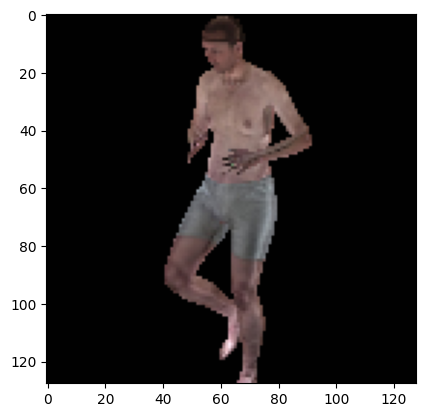

In [6]:
renderer.show()

In [7]:

tgt = remove_background(image_path,seg_mask_path)
tgt = squared_image(tgt)
# plt.imshow(tgt)
# tgt.shape
# resize the image to 512,512
from skimage.transform import resize
tgt = resize(tgt,(image_resolution,image_resolution))


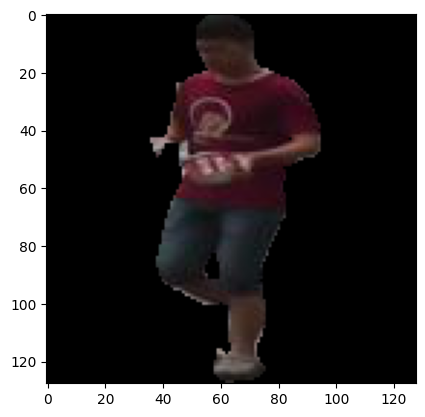

In [8]:
plt.imshow(tgt)

In [9]:

def tv_loss(tex):
    tv = torch.mean(torch.abs(tex[:, :, :, :-1] - tex[:, :, :, 1:])) + \
               torch.mean(torch.abs(tex[:, :, :-1, :] - tex[:, :, 1:, :]))
    return tv

In [10]:
# diff = images[0,...,:3] - torch.from_numpy(tgt).to(device)
# loss = torch.sum(diff**2)
# loss.backward()

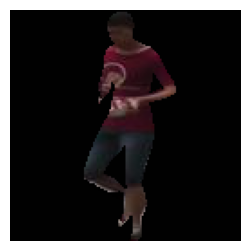

loss: 211.65988198680947


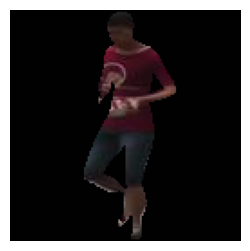

loss: 210.79797892097218


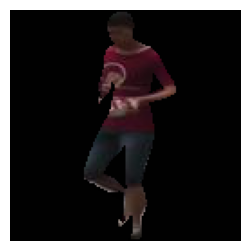

loss: 210.54284227642327


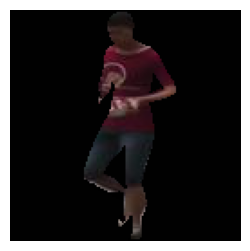

loss: 210.4584044469916


In [17]:
# training loop to learn texture and T from image
params = [ renderer.texture_map] #renderer.verts,renderer.T
optim = torch.optim.Adam(params,lr=0.1)
for i in range(1000):
    optim.zero_grad()
    images = renderer.render()
    diff = images[0,...,:3] - torch.from_numpy(tgt).to(device)
    loss = torch.sum(diff**2) + 0.5 * tv_loss(renderer.texture_map)
    loss.backward()
    optim.step()
    # print(loss.item())
    if i%300 == 0:
        plt.figure(figsize=(3,3))
        plt.imshow(images[0,...,:3].cpu().detach().numpy().clip(0,1))
        plt.axis('off')
        plt.show()
        
        # print(renderer.T)
        # print(renderer.texture_map)
        # print(renderer.verts)
        print('loss:',loss.item())
 


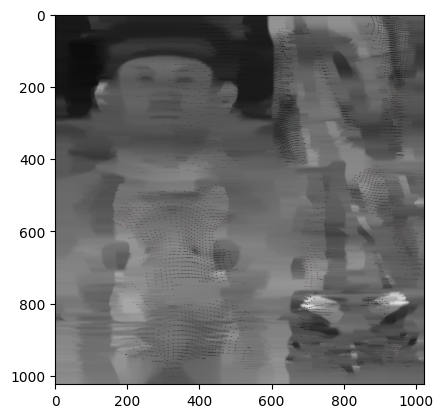

In [18]:
import numpy as np
texture = renderer.texture_map.cpu().detach().numpy()[0]
texture = texture/255
# texture = np.transpose(texture,(1,2,0))
plt.imshow(texture.clip(0,1))


In [13]:
# save texture
# plt.imsave("data/exp/changed_texture_re.jpg",texture.clip(0,1))